In [1]:
# Необходимо для корректной работы внешних .py файлов
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler, TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from helper import *
from plots import *
from timeit import default_timer as timer
import random
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from skopt.space import Integer, Real, Categorical
from skopt import BayesSearchCV

In [3]:
# фиксируем состояние генератора псевдослучайных чисел. Это необходимо, чтобы результаты модели не менялись с каждым новым запуском 
SEED = 42 # можно указать любое число
np.random.seed(SEED)
random.seed(SEED)

In [11]:
df = pd.read_csv("data.csv", sep=";")

## 1. Предобработка

In [12]:
# Общие преобразования
df_preprocessed = df.copy()

num_cols = ['balance', 'age', 'day','duration','campaign','pdays','previous']
for c in num_cols:
    df_preprocessed[c] = pd.to_numeric(df_preprocessed[c], errors='coerce')

for c in ['job','marital','education','default','housing','loan','contact','poutcome','month','y']:
    df_preprocessed[c] = df_preprocessed[c].astype('category')

# Упорядочим month
#months_order = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
#df_preprocessed['month'] = pd.Categorical(df_preprocessed['month'], categories=months_order, ordered=True)
# флаг для специального значения pdays == -1
df_preprocessed['pdays_never'] = (df_preprocessed['pdays'] == -1).astype('int8')

# Кодирование таргета
df_preprocessed['y'] = np.where(df_preprocessed['y'] == 'yes', 1, 0)

df_preprocessed.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,pdays_never
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0,1
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0,1
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0,1


In [13]:
# делим данные на признаки и таргет
X, y = divide_data(df_preprocessed, 'y')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

In [14]:
categorical_cols = ['job','marital','education','default','housing','loan',
                    'contact','month','poutcome']
numeric_cols = ['age','balance','day','campaign','pdays','previous','pdays_never']

# Будем использовать порядковое кодирование. Для этого выпишем все категории для каждого столбца в порядке увеличения номера
cat_orders = [
    # job
    ['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management',
     'retired', 'self-employed', 'services', 'student', 'technician',
     'unemployed', 'unknown'],
    # marital
    ['divorced', 'married', 'single'],
    # education
    ['primary', 'secondary', 'tertiary', 'unknown'],
    # default / housing / loan
    ['no', 'yes'],
    ['no', 'yes'],
    ['no', 'yes'],
    # contact
    ['unknown', 'telephone', 'cellular'],
    # month
    ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'],
    # poutcome
    ['failure', 'other', 'success', 'unknown']
]

scale_cols = ['balance', 'campaign', 'previous']
# пайплайн
preprocessor = Pipeline([
    ('nan_remover', ColumnTransformer(
        transformers=[
            ('most_frequent_numeric', SimpleImputer(strategy='most_frequent'), numeric_cols),
            ('most_frequent_cat',    SimpleImputer(strategy='most_frequent'), categorical_cols),
            ('mean',                 SimpleImputer(strategy='mean'),          []),
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    )),
    ('transformations', ColumnTransformer(
        [('encoder', OrdinalEncoder(categories=cat_orders), categorical_cols),
         ('scaler',  StandardScaler(), scale_cols),],
        remainder='passthrough',
        verbose_feature_names_out=False
    )),
])
preprocessor.set_output(transform='pandas')

,steps,"[('nan_remover', ...), ('transformations', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('most_frequent_numeric', ...), ('most_frequent_cat', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [15]:
base_model = ('LGBMClassifier', LGBMClassifier(random_state=SEED))

In [16]:
preprocessor.steps.append(base_model)
pipeline = preprocessor

[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 992
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327


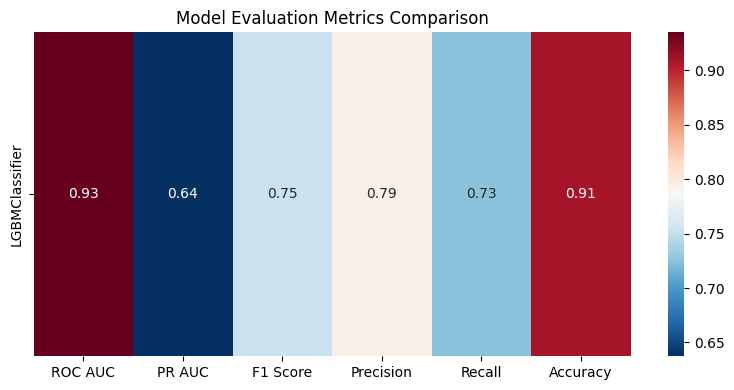

In [17]:
initial_metrics = train_evaluate_models(
    models=[('LGBMClassifier', pipeline)],
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    seed=SEED
)

In [18]:
initial_metrics

,ROC AUC,PR AUC,F1 Score,Precision,Recall,Accuracy
LGBMClassifier,0.934676,0.637335,0.753147,0.794319,0.725059,0.909764


## 2. Подбор гиперпараметров

In [19]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

### 2.1 Grid Search

In [20]:
param_grid = {
    # Контроль сложности модели и переобучения
    "LGBMClassifier__num_leaves": [7, 31, 63],  # Максимальное количество листьев в дереве (влияет на сложность модели)
    "LGBMClassifier__max_depth": [5, 7, 9],     # Максимальная глубина дерева (ограничивает сложность)
    "LGBMClassifier__min_child_samples": [10, 20, 50],  # Минимальное количество данных в листе (контроль переобучения)
    
    # Скорость обучения и количество итераций бустинга
    "LGBMClassifier__learning_rate": [0.02, 0.05, 0.1],  # Скорость обучения (шаг градиентного спуска)
    "LGBMClassifier__n_estimators": [200, 400, 800, 1200],  # Количество деревьев в ансамбле
    
    # Регуляризация
    # "LGBMClassifier__reg_alpha": [0, 0.1, 1],   # L1-регуляризация (лассо)
    # "LGBMClassifier__reg_lambda": [0, 0.1, 1],  # L2-регуляризация (ридж)
    
    # Сэмплирование признаков
    # "LGBMClassifier__feature_fraction": [0.7, 0.9, 1.0],  # Доля признаков для использования при построении каждого дерева
    # "LGBMClassifier__bagging_fraction": [0.7, 0.9],       # Доля данных для использования в каждом бустинговом раунде
    # "LGBMClassifier__bagging_freq": [0, 1],               # Частота бэггинга (0 - отключен)
    
    # # Другие параметры
    # "LGBMClassifier__subsample": [0.8, 1.0],               # Доля случайных примеров для обучения каждого дерева
    # "LGBMClassifier__colsample_bytree": [0.7, 0.9, 1.0],   # Доля признаков для каждого дерева
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='average_precision',
    cv=cv,
    n_jobs=-1,
    verbose=3
)

In [21]:
grid_search_start = timer()
grid_search.fit(X_train, y_train)
grid_search_end = timer()

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 992
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [22]:
print(f"Total time: {grid_search_end - grid_search_start:.2f} seconds")

Total time: 2381.34 seconds


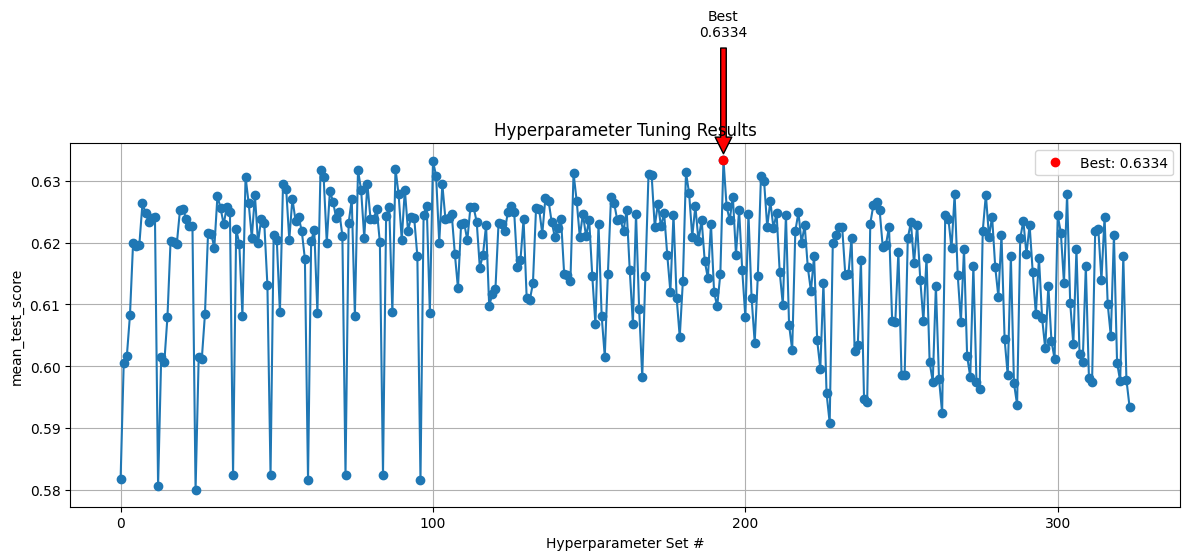

In [23]:
data = plot_hyperparam_search_results(grid_search.cv_results_, xtick_step=100)

In [24]:
grid_search.best_params_

{'LGBMClassifier__learning_rate': 0.05,
 'LGBMClassifier__max_depth': 9,
 'LGBMClassifier__min_child_samples': 20,
 'LGBMClassifier__n_estimators': 200,
 'LGBMClassifier__num_leaves': 31}

In [25]:
grid_search_best_model = grid_search.best_estimator_

[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 992
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


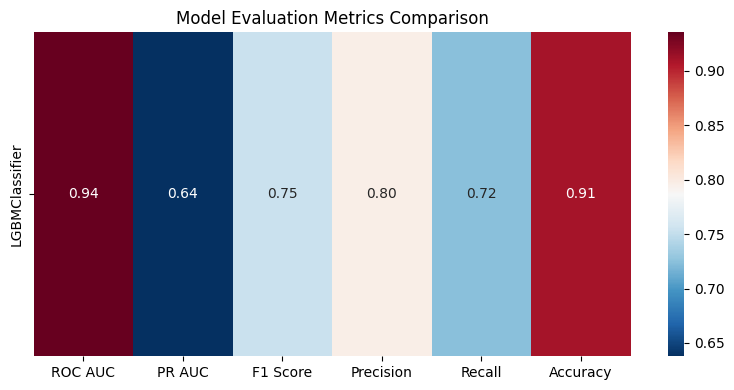

In [26]:
grid_search_metrics = train_evaluate_models(
    models=[('LGBMClassifier', grid_search_best_model)],
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    seed=SEED
)

In [27]:
grid_search_metrics

,ROC AUC,PR AUC,F1 Score,Precision,Recall,Accuracy
LGBMClassifier,0.935215,0.637794,0.753351,0.796907,0.724142,0.910317


(<Figure size 800x400 with 2 Axes>,
                  ROC AUC    PR AUC  F1 Score  Precision    Recall  Accuracy
 LGBMClassifier  0.000539  0.000459  0.000204   0.002588 -0.000917  0.000553)

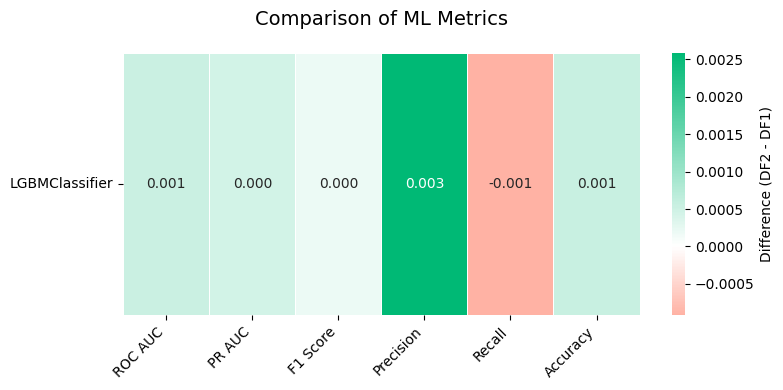

In [28]:
compare_metrics_heatmap(initial_metrics, grid_search_metrics)

### 2.2 Randomized search

In [29]:
param_dist = {
    "LGBMClassifier__num_leaves": sp_randint(16, 128), 
    "LGBMClassifier__max_depth": sp_randint(3, 8), 
    "LGBMClassifier__min_child_samples": sp_randint(10, 20, 50),
    
    "LGBMClassifier__learning_rate": sp_uniform(0.01, 0.1),
    "LGBMClassifier__n_estimators": sp_randint(200, 1000),  
}

In [30]:
randomized_search = RandomizedSearchCV(
    random_state=SEED,
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=100,
    scoring='average_precision',
    cv=cv,
    n_jobs=-1,
    verbose=3
)

In [31]:
randomized_search_start = timer()
randomized_search.fit(X_train, y_train)
randomized_search_end = timer()

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 992
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

In [32]:
print(f"Total time: {randomized_search_end - randomized_search_start:.2f} seconds")

Total time: 411.79 seconds


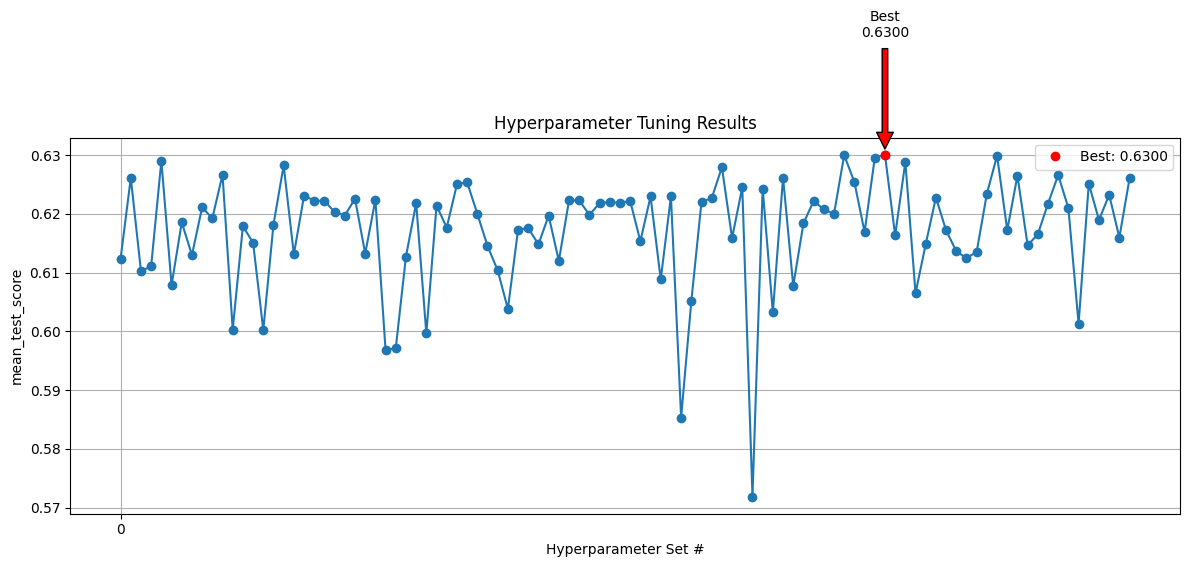

In [33]:
data = plot_hyperparam_search_results(randomized_search.cv_results_, xtick_step=100)

In [34]:
randomized_search.best_params_

{'LGBMClassifier__learning_rate': np.float64(0.013050024993904943),
 'LGBMClassifier__max_depth': 6,
 'LGBMClassifier__min_child_samples': 69,
 'LGBMClassifier__n_estimators': 982,
 'LGBMClassifier__num_leaves': 69}

[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 992
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

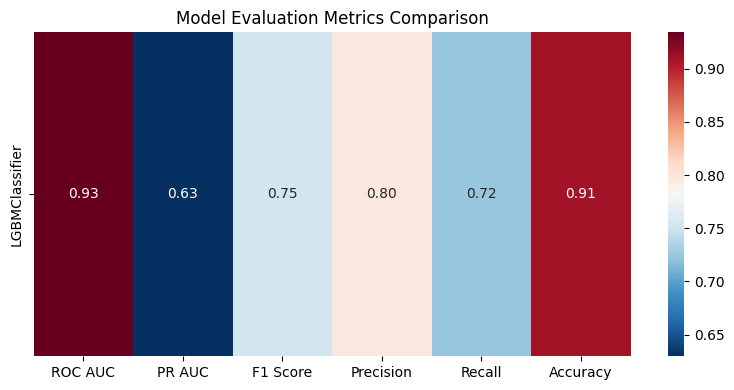

In [35]:
randomized_search_metrics = train_evaluate_models(
    models=[('LGBMClassifier', randomized_search.best_estimator_)],
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    seed=SEED
)

In [36]:
randomized_search_metrics

,ROC AUC,PR AUC,F1 Score,Precision,Recall,Accuracy
LGBMClassifier,0.93431,0.629649,0.752574,0.797975,0.722565,0.910428


(<Figure size 800x400 with 2 Axes>,
                  ROC AUC    PR AUC  F1 Score  Precision    Recall  Accuracy
 LGBMClassifier -0.000366 -0.007685 -0.000573   0.003656 -0.002494  0.000663)

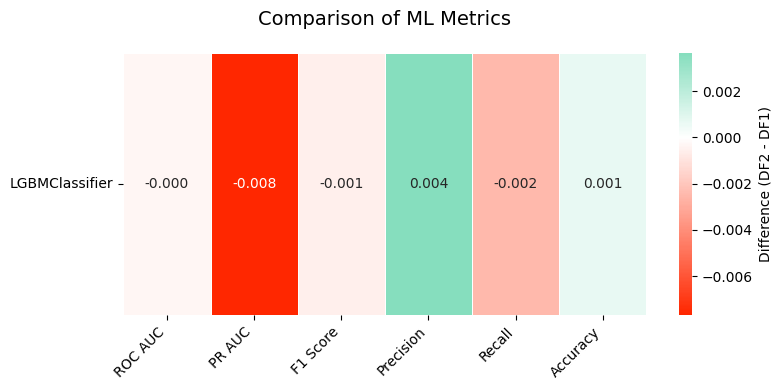

In [37]:
compare_metrics_heatmap(initial_metrics, randomized_search_metrics)

### 2.3 Bayes Search

In [38]:
param_bayes = {
    "LGBMClassifier__num_leaves": Integer(7, 31), 
    "LGBMClassifier__max_depth": Integer(3, 7),  
    "LGBMClassifier__min_child_samples": Integer(5, 20), 
    
    # Логарифмическая шкала используется потому что:
    # 1) learning_rate обычно варьируется в порядках величины (0.001-0.1)
    # 2) Логарифмирование дает более равномерный поиск в широком диапазоне значений
    # 3) Разница между 0.01 и 0.02 часто значительнее, чем между 0.1 и 0.11
    "LGBMClassifier__learning_rate": Real(0.01, 0.1, prior='log-uniform'),
    
    "LGBMClassifier__n_estimators": Integer(10, 200), 
}

In [39]:
bayes_search = BayesSearchCV(
    random_state=SEED,
    estimator=pipeline,
    search_spaces=param_bayes,
    n_iter=100, 
    cv=cv,      
    scoring='average_precision',  
    optimizer_kwargs={'base_estimator': 'GP'}, 
    verbose=3,
    n_jobs=1 
)

In [40]:
bayes_search_start = timer()
bayes_search.fit(X_train, y_train)
bayes_search_end = timer()

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Number of positive: 3385, number of negative: 25549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 989
[LightGBM] [Info] Number of data points in the train set: 28934, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116990 -> initscore=-2.021244
[LightGBM] [Info] Start training from score -2.021244
[CV 1/5] END LGBMClassifier__learning_rate=0.02571011142608906, LGBMClassifier__max_depth=6, LGBMClassifier__min_child_samples=19, LGBMClassifier__n_estimators=70, LGBMClassifier__num_leaves=23;, score=0.563 total time=   0.2s
[LightGBM] [Info] Number of positive: 3385, number of negative: 25549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.

In [41]:
print(f"Total time: {bayes_search_end - bayes_search_start:.2f} seconds")

Total time: 276.94 seconds


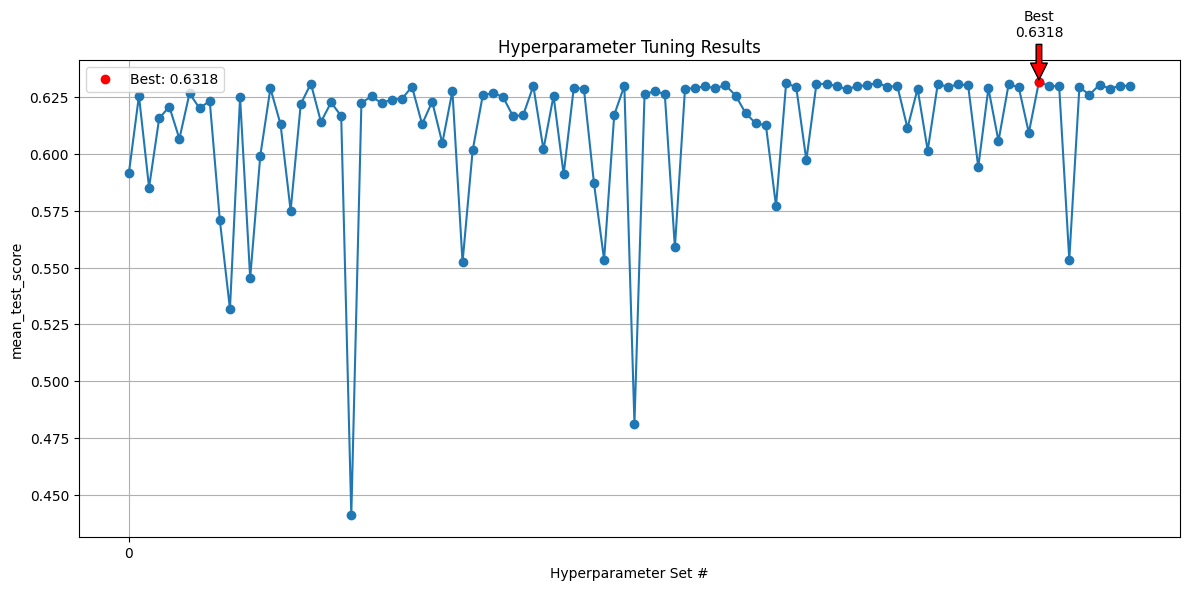

In [42]:
data = plot_hyperparam_search_results(bayes_search.cv_results_, xtick_step=100)

In [43]:
bayes_search.best_params_

OrderedDict([('LGBMClassifier__learning_rate', 0.04397054256819899),
             ('LGBMClassifier__max_depth', 7),
             ('LGBMClassifier__min_child_samples', 20),
             ('LGBMClassifier__n_estimators', 200),
             ('LGBMClassifier__num_leaves', 26)])

[LightGBM] [Info] Number of positive: 4231, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 992
[LightGBM] [Info] Number of data points in the train set: 36168, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116982 -> initscore=-2.021327
[LightGBM] [Info] Start training from score -2.021327


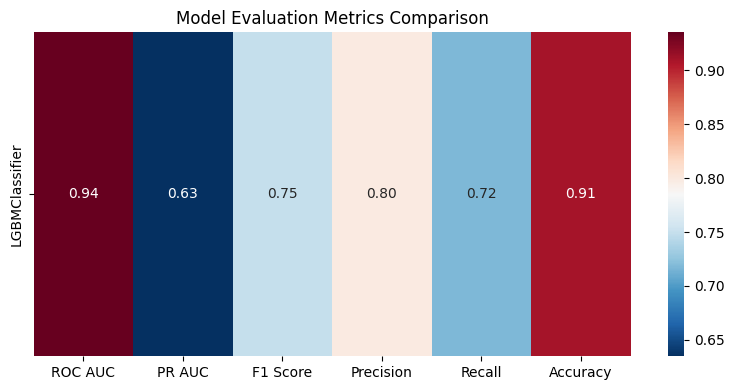

In [44]:
bayes_search_metrics = train_evaluate_models(
    models=[('LGBMClassifier', bayes_search.best_estimator_)],
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    seed=SEED
)

In [45]:
bayes_search_metrics

,ROC AUC,PR AUC,F1 Score,Precision,Recall,Accuracy
LGBMClassifier,0.935145,0.634838,0.749083,0.798631,0.717458,0.910096


(<Figure size 800x400 with 2 Axes>,
                  ROC AUC    PR AUC  F1 Score  Precision    Recall  Accuracy
 LGBMClassifier  0.000469 -0.002496 -0.004064   0.004312 -0.007602  0.000332)

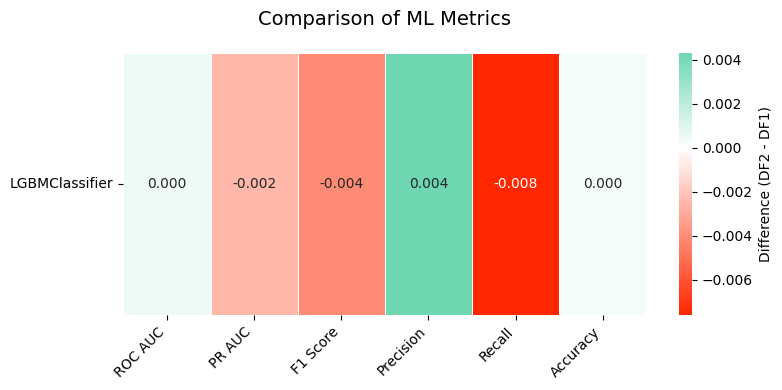

In [46]:
compare_metrics_heatmap(initial_metrics, bayes_search_metrics)

(<Figure size 800x400 with 2 Axes>,
                  ROC AUC    PR AUC  F1 Score  Precision    Recall  Accuracy
 LGBMClassifier -0.000071 -0.002956 -0.004268   0.001724 -0.006685 -0.000221)

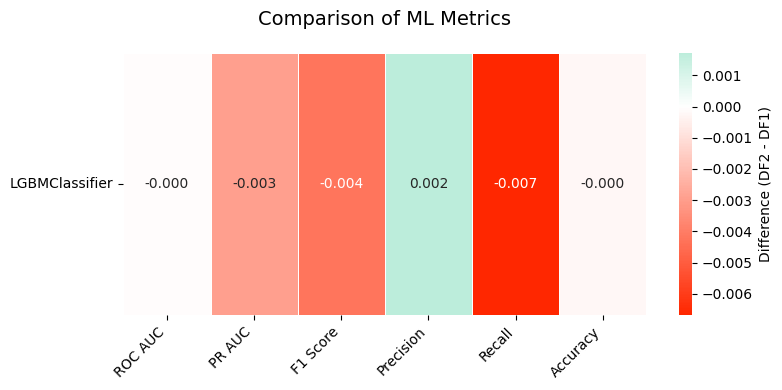

In [47]:
compare_metrics_heatmap(grid_search_metrics, bayes_search_metrics)